# Deep Learning: Endoscopy segmentation.
[Dataset](https://www.kaggle.com/datasets/newslab/cholecseg8k?resource=download)

In [1]:
import os

os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:8"

In [2]:
import torch
from glob import glob
import numpy as np
import time
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import cv2
import random
from pytorch_Uformer import model
from pytorch_Uformer import losses
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [3]:
torch.cuda.is_available(), torch.cuda.get_device_name(0)

(True, 'NVIDIA GeForce RTX 2060 SUPER')

In [4]:
SEED = 33
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.use_deterministic_algorithms(True)

In [5]:
# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False

NUM_CLASSES = 13
# initialize learning rate, number of epochs to train for, and the
# batch size
INIT_LR = 0.0015
NUM_EPOCHS = 100
BATCH_SIZE = 45
# define the input image dimensions
INPUT_IMAGE_WIDTH = 64
INPUT_IMAGE_HEIGHT = 64

## Data preparation.

In [6]:
IMAGE_DATASET_PATH = glob(f'../*/*/*/frame_*_endo.png')
MASK_DATASET_PATH  = glob(f'../*/*/*/frame_*_endo_watershed_mask.png')
N = len(IMAGE_DATASET_PATH)
assert len(IMAGE_DATASET_PATH) == len(MASK_DATASET_PATH)

print(f'Number of samples: {str(len(MASK_DATASET_PATH))}')

Number of samples: 8080


In [7]:
def to_categorical(y, num_classes=None, dtype="float32"):
	y = np.array(y, dtype="int")
	input_shape = y.shape

	# Shrink the last dimension if the shape is (..., 1).
	if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
		input_shape = tuple(input_shape[:-1])

	y = y.reshape(-1)
	if not num_classes:
		num_classes = np.max(y) + 1
	n = y.shape[0]
	categorical = np.zeros((n, num_classes), dtype=dtype)
	categorical[np.arange(n), y] = 1
	output_shape = input_shape + (num_classes,)
	categorical = np.reshape(categorical, output_shape)
	return categorical

labels = [[11],[21],[13],[12],[31],[23],[24],[25],[32],[22],[33],[5]]
def encode_mask(masks_arr, n_classes=NUM_CLASSES, H=INPUT_IMAGE_HEIGHT, W=INPUT_IMAGE_WIDTH, labels_arr=labels):
    y_encoded = np.zeros((H, W, 1), dtype=np.uint8)

    for i, label in enumerate(labels_arr):
        y_encoded[np.all(label == masks_arr, axis=-1)] = i + 1
    
    return to_categorical(y_encoded, num_classes=n_classes)

class SegmentationDataset(Dataset):
	def __init__(self, imagePaths, maskPaths):
		# store the image and mask filepaths, and augmentation
		# transforms
		self.imagePaths = imagePaths
		self.maskPaths = maskPaths

	def __len__(self):
		# return the number of total samples contained in the dataset
		return len(self.imagePaths)
	
	def __getitem__(self, idx):
		# grab the image path from the current index
		imagePath = self.imagePaths[idx]
		# load the image from disk, swap its channels from BGR to RGB,
		# and read the associated mask from disk in grayscale mode
		image = cv2.imread(imagePath)
		image = image[10:-10, 10:-10,:]
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		image = cv2.resize(image, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT))
		image = image / 255
		image = torch.from_numpy(np.float32(image))
		image = image.permute(2,0,1)

		mask = cv2.imread(self.maskPaths[idx])
		mask = mask[10:-10, 10:-10,:]
		mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
		mask = cv2.resize(mask, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT), interpolation=cv2.INTER_NEAREST)
		mask = np.expand_dims(mask, axis=-1)
		mask = encode_mask(mask)
		mask = torch.from_numpy(np.float32(mask))
		mask = mask.permute(2,0,1)

		assert image.shape == (3, INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH), f"Bad image shape {image.shape}"
		assert mask.shape == (13, INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH), f"Bad mask shape {mask.shape}"

		# return a tuple of the image and its mask
		return image, mask

In [8]:
uformer = model.Uformer(img_size=INPUT_IMAGE_HEIGHT,in_chans=13, embed_dim=16, win_size=8, token_projection='linear', token_mlp='leff',modulator=True)
trainImages, testImages, trainMasks, testMasks = train_test_split(IMAGE_DATASET_PATH, MASK_DATASET_PATH, test_size=0.2, random_state=43)

c:\Users\alexg\miniconda3\envs\pytorch-gpu\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [9]:
# define transformations
from torch.utils.data import DataLoader

# create the train and test datasets
trainDS = SegmentationDataset(imagePaths=trainImages, maskPaths=trainMasks)
testDS = SegmentationDataset(imagePaths=testImages, maskPaths=testMasks)
print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")
# create the training and test data loaders
num_workers = 4
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

trainLoader = DataLoader(
	trainDS, 
	shuffle=True,
	batch_size=BATCH_SIZE, 
	pin_memory=PIN_MEMORY,
    worker_init_fn=seed_worker,
    generator=g
)
testLoader = DataLoader(
	testDS, shuffle=False,
	batch_size=BATCH_SIZE, 
	pin_memory=PIN_MEMORY,
    worker_init_fn=seed_worker,
    generator=g
)

[INFO] found 6464 examples in the training set...
[INFO] found 1616 examples in the test set...


In [10]:
uformer = uformer.to(DEVICE)
softmax = torch.nn.Softmax(1)
# initialize loss function and optimizer
lossFunc = losses.TverskyLoss().cuda()
opt = torch.optim.Adam(uformer.parameters(), lr=INIT_LR, betas=(0.9, 0.999),eps=1e-8, weight_decay=1e-5)
iouMetric = losses.MeanIoU().cuda()
gdlMetric = losses.DiceCoeficient().cuda()
# calculate steps per epoch for training and test set
trainSteps = len(trainDS) // BATCH_SIZE
testSteps = len(testDS) // BATCH_SIZE
# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": [], "train_IoU": [], "test_IoU": [],"train_DC": [], "test_DC": []}

In [11]:
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in range(NUM_EPOCHS):
	# set the model in training mode
	uformer.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalTestLoss = 0

	totalTrainIoU = 0
	totalTestIoU = 0
	totalTrainDC = 0
	totalTestDC = 0
	# loop over the training set
	for i, (x, y) in enumerate(tqdm(trainLoader)):
		# send the input to the device
		x, y = x.to(DEVICE), y.to(DEVICE)
		# perform a forward pass and calculate the training loss
		pred = uformer(x)
		assert pred.shape == y.shape, f"{pred.shape} != {y.shape}" # B, C, H, W
		pred = softmax(pred)
		loss = lossFunc(pred, y)
		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
		opt.zero_grad()
		loss.backward()
		opt.step()
		# add the loss to the total training loss so far
		totalTrainLoss += loss
		totalTrainIoU += iouMetric(pred, y)
		totalTrainDC += gdlMetric(pred, y)
	# switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		uformer.eval()
		# loop over the validation set
		for (x, y) in testLoader:
			# send the input to the device
			(x, y) = (x.to(DEVICE), y.to(DEVICE))
			# make the predictions and calculate the validation loss
			pred = uformer(x)
			assert pred.shape == y.shape, f"{pred.shape} != {y.shape}" # B, C, H, W
			pred = softmax(pred)
			totalTestLoss += lossFunc(pred, y)
			totalTestIoU += iouMetric(pred, y)
			totalTestDC += gdlMetric(pred, y)
			
	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgTestLoss = totalTestLoss / testSteps

	avgTrainIoU = totalTrainIoU / trainSteps
	avgTestIoU = totalTestIoU / testSteps
	avgTrainDC = totalTrainDC / trainSteps
	avgTestDC = totalTestDC / testSteps
	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["test_loss"].append(avgTestLoss.cpu().detach().numpy())

	H["train_IoU"].append(avgTrainIoU.cpu().detach().numpy())
	H["test_IoU"].append(avgTestIoU.cpu().detach().numpy())
	H["train_DC"].append(avgTrainDC.cpu().detach().numpy())
	H["test_DC"].append(avgTestDC.cpu().detach().numpy())

	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
	print(f"Train loss: {avgTrainLoss:.6f}, Test loss: {avgTestLoss:.4f}, " + 
       f"Train IoU: {avgTrainIoU:.4f}, Test IoU: {avgTestIoU:.4f}, Train Dice: {avgTrainDC:.4f}, Test Dice: {avgTestDC:.4f}")

# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))

[INFO] training the network...


100%|██████████| 144/144 [01:53<00:00,  1.27it/s]


[INFO] EPOCH: 1/100
Train loss: 0.477178, Test loss: 0.2915, Train IoU: 0.3726, Test IoU: 0.5749, Train Dice: 0.5298, Test Dice: 0.7371


100%|██████████| 144/144 [01:55<00:00,  1.25it/s]


[INFO] EPOCH: 2/100
Train loss: 0.228773, Test loss: 0.2173, Train IoU: 0.6358, Test IoU: 0.6711, Train Dice: 0.7782, Test Dice: 0.8112


100%|██████████| 144/144 [01:59<00:00,  1.20it/s]


[INFO] EPOCH: 3/100
Train loss: 0.204789, Test loss: 0.2006, Train IoU: 0.6680, Test IoU: 0.6940, Train Dice: 0.8022, Test Dice: 0.8279


100%|██████████| 144/144 [01:59<00:00,  1.20it/s]


[INFO] EPOCH: 4/100
Train loss: 0.190857, Test loss: 0.1924, Train IoU: 0.6873, Test IoU: 0.7056, Train Dice: 0.8161, Test Dice: 0.8361


100%|██████████| 144/144 [01:58<00:00,  1.22it/s]


[INFO] EPOCH: 5/100
Train loss: 0.185906, Test loss: 0.1888, Train IoU: 0.6943, Test IoU: 0.7107, Train Dice: 0.8211, Test Dice: 0.8398


100%|██████████| 144/144 [01:57<00:00,  1.22it/s]


[INFO] EPOCH: 6/100
Train loss: 0.182830, Test loss: 0.1875, Train IoU: 0.6985, Test IoU: 0.7126, Train Dice: 0.8242, Test Dice: 0.8411


100%|██████████| 144/144 [01:58<00:00,  1.22it/s]


[INFO] EPOCH: 7/100
Train loss: 0.180357, Test loss: 0.1837, Train IoU: 0.7021, Test IoU: 0.7179, Train Dice: 0.8266, Test Dice: 0.8449


100%|██████████| 144/144 [01:57<00:00,  1.22it/s]


[INFO] EPOCH: 8/100
Train loss: 0.180171, Test loss: 0.1823, Train IoU: 0.7022, Test IoU: 0.7198, Train Dice: 0.8268, Test Dice: 0.8463


100%|██████████| 144/144 [01:58<00:00,  1.22it/s]


[INFO] EPOCH: 9/100
Train loss: 0.177324, Test loss: 0.1818, Train IoU: 0.7063, Test IoU: 0.7204, Train Dice: 0.8297, Test Dice: 0.8467


100%|██████████| 144/144 [01:57<00:00,  1.22it/s]


[INFO] EPOCH: 10/100
Train loss: 0.177013, Test loss: 0.1814, Train IoU: 0.7067, Test IoU: 0.7210, Train Dice: 0.8300, Test Dice: 0.8472


100%|██████████| 144/144 [01:58<00:00,  1.21it/s]


[INFO] EPOCH: 11/100
Train loss: 0.176236, Test loss: 0.1789, Train IoU: 0.7078, Test IoU: 0.7241, Train Dice: 0.8308, Test Dice: 0.8497


100%|██████████| 144/144 [02:00<00:00,  1.19it/s]


[INFO] EPOCH: 12/100
Train loss: 0.164502, Test loss: 0.1342, Train IoU: 0.7268, Test IoU: 0.7919, Train Dice: 0.8425, Test Dice: 0.8944


100%|██████████| 144/144 [02:00<00:00,  1.19it/s]


[INFO] EPOCH: 13/100
Train loss: 0.123642, Test loss: 0.1235, Train IoU: 0.7874, Test IoU: 0.8087, Train Dice: 0.8834, Test Dice: 0.9051


100%|██████████| 144/144 [02:01<00:00,  1.19it/s]


[INFO] EPOCH: 14/100
Train loss: 0.117217, Test loss: 0.1203, Train IoU: 0.7978, Test IoU: 0.8139, Train Dice: 0.8898, Test Dice: 0.9083


100%|██████████| 144/144 [01:57<00:00,  1.22it/s]


[INFO] EPOCH: 15/100
Train loss: 0.112541, Test loss: 0.1068, Train IoU: 0.8054, Test IoU: 0.8360, Train Dice: 0.8945, Test Dice: 0.9218


100%|██████████| 144/144 [01:57<00:00,  1.23it/s]


[INFO] EPOCH: 16/100
Train loss: 0.101353, Test loss: 0.1027, Train IoU: 0.8237, Test IoU: 0.8427, Train Dice: 0.9056, Test Dice: 0.9259


100%|██████████| 144/144 [01:58<00:00,  1.21it/s]


[INFO] EPOCH: 17/100
Train loss: 0.098596, Test loss: 0.1029, Train IoU: 0.8281, Test IoU: 0.8422, Train Dice: 0.9084, Test Dice: 0.9257


100%|██████████| 144/144 [01:59<00:00,  1.21it/s]


[INFO] EPOCH: 18/100
Train loss: 0.098599, Test loss: 0.0991, Train IoU: 0.8282, Test IoU: 0.8484, Train Dice: 0.9084, Test Dice: 0.9294


100%|██████████| 144/144 [01:58<00:00,  1.21it/s]


[INFO] EPOCH: 19/100
Train loss: 0.095977, Test loss: 0.0980, Train IoU: 0.8325, Test IoU: 0.8503, Train Dice: 0.9110, Test Dice: 0.9305


100%|██████████| 144/144 [01:56<00:00,  1.23it/s]


[INFO] EPOCH: 20/100
Train loss: 0.095840, Test loss: 0.0999, Train IoU: 0.8327, Test IoU: 0.8471, Train Dice: 0.9112, Test Dice: 0.9286


100%|██████████| 144/144 [01:56<00:00,  1.23it/s]


[INFO] EPOCH: 21/100
Train loss: 0.095449, Test loss: 0.0981, Train IoU: 0.8333, Test IoU: 0.8502, Train Dice: 0.9115, Test Dice: 0.9305


100%|██████████| 144/144 [01:58<00:00,  1.22it/s]


[INFO] EPOCH: 22/100
Train loss: 0.094902, Test loss: 0.0979, Train IoU: 0.8342, Test IoU: 0.8504, Train Dice: 0.9121, Test Dice: 0.9307


100%|██████████| 144/144 [01:55<00:00,  1.24it/s]


[INFO] EPOCH: 23/100
Train loss: 0.086707, Test loss: 0.0798, Train IoU: 0.8482, Test IoU: 0.8811, Train Dice: 0.9203, Test Dice: 0.9487


100%|██████████| 144/144 [01:54<00:00,  1.25it/s]


[INFO] EPOCH: 24/100
Train loss: 0.076842, Test loss: 0.0769, Train IoU: 0.8648, Test IoU: 0.8860, Train Dice: 0.9302, Test Dice: 0.9517


100%|██████████| 144/144 [01:55<00:00,  1.25it/s]


[INFO] EPOCH: 25/100
Train loss: 0.074336, Test loss: 0.0749, Train IoU: 0.8691, Test IoU: 0.8895, Train Dice: 0.9327, Test Dice: 0.9536


100%|██████████| 144/144 [01:54<00:00,  1.25it/s]


[INFO] EPOCH: 26/100
Train loss: 0.074170, Test loss: 0.0783, Train IoU: 0.8694, Test IoU: 0.8836, Train Dice: 0.9328, Test Dice: 0.9502


100%|██████████| 144/144 [01:55<00:00,  1.25it/s]


[INFO] EPOCH: 27/100
Train loss: 0.075540, Test loss: 0.0760, Train IoU: 0.8670, Test IoU: 0.8875, Train Dice: 0.9315, Test Dice: 0.9525


100%|██████████| 144/144 [01:54<00:00,  1.25it/s]


[INFO] EPOCH: 28/100
Train loss: 0.072640, Test loss: 0.0740, Train IoU: 0.8720, Test IoU: 0.8911, Train Dice: 0.9344, Test Dice: 0.9546


100%|██████████| 144/144 [01:54<00:00,  1.26it/s]


[INFO] EPOCH: 29/100
Train loss: 0.072072, Test loss: 0.0738, Train IoU: 0.8729, Test IoU: 0.8913, Train Dice: 0.9349, Test Dice: 0.9548


100%|██████████| 144/144 [01:58<00:00,  1.22it/s]


[INFO] EPOCH: 30/100
Train loss: 0.072268, Test loss: 0.0731, Train IoU: 0.8726, Test IoU: 0.8925, Train Dice: 0.9347, Test Dice: 0.9554


100%|██████████| 144/144 [01:57<00:00,  1.22it/s]


[INFO] EPOCH: 31/100
Train loss: 0.071288, Test loss: 0.0726, Train IoU: 0.8743, Test IoU: 0.8934, Train Dice: 0.9357, Test Dice: 0.9560


100%|██████████| 144/144 [01:57<00:00,  1.22it/s]


[INFO] EPOCH: 32/100
Train loss: 0.076057, Test loss: 0.0804, Train IoU: 0.8661, Test IoU: 0.8799, Train Dice: 0.9309, Test Dice: 0.9482


100%|██████████| 144/144 [01:58<00:00,  1.21it/s]


[INFO] EPOCH: 33/100
Train loss: 0.071418, Test loss: 0.0660, Train IoU: 0.8741, Test IoU: 0.9051, Train Dice: 0.9356, Test Dice: 0.9625


100%|██████████| 144/144 [01:58<00:00,  1.22it/s]


[INFO] EPOCH: 34/100
Train loss: 0.058723, Test loss: 0.0583, Train IoU: 0.8966, Test IoU: 0.9189, Train Dice: 0.9483, Test Dice: 0.9703


100%|██████████| 144/144 [01:57<00:00,  1.23it/s]


[INFO] EPOCH: 35/100
Train loss: 0.054612, Test loss: 0.0558, Train IoU: 0.9039, Test IoU: 0.9233, Train Dice: 0.9524, Test Dice: 0.9728


100%|██████████| 144/144 [01:56<00:00,  1.23it/s]


[INFO] EPOCH: 36/100
Train loss: 0.052773, Test loss: 0.0540, Train IoU: 0.9072, Test IoU: 0.9264, Train Dice: 0.9542, Test Dice: 0.9745


100%|██████████| 144/144 [01:55<00:00,  1.25it/s]


[INFO] EPOCH: 37/100
Train loss: 0.051329, Test loss: 0.0534, Train IoU: 0.9099, Test IoU: 0.9275, Train Dice: 0.9557, Test Dice: 0.9751


100%|██████████| 144/144 [01:55<00:00,  1.25it/s]


[INFO] EPOCH: 38/100
Train loss: 0.051112, Test loss: 0.0528, Train IoU: 0.9102, Test IoU: 0.9287, Train Dice: 0.9559, Test Dice: 0.9758


100%|██████████| 144/144 [01:55<00:00,  1.25it/s]


[INFO] EPOCH: 39/100
Train loss: 0.050129, Test loss: 0.0525, Train IoU: 0.9120, Test IoU: 0.9290, Train Dice: 0.9569, Test Dice: 0.9760


100%|██████████| 144/144 [01:54<00:00,  1.25it/s]


[INFO] EPOCH: 40/100
Train loss: 0.049885, Test loss: 0.0529, Train IoU: 0.9124, Test IoU: 0.9284, Train Dice: 0.9571, Test Dice: 0.9757


100%|██████████| 144/144 [01:55<00:00,  1.25it/s]


[INFO] EPOCH: 41/100
Train loss: 0.051016, Test loss: 0.0531, Train IoU: 0.9104, Test IoU: 0.9281, Train Dice: 0.9560, Test Dice: 0.9754


100%|██████████| 144/144 [01:54<00:00,  1.25it/s]


[INFO] EPOCH: 42/100
Train loss: 0.049295, Test loss: 0.0519, Train IoU: 0.9134, Test IoU: 0.9303, Train Dice: 0.9577, Test Dice: 0.9767


100%|██████████| 144/144 [01:55<00:00,  1.25it/s]


[INFO] EPOCH: 43/100
Train loss: 0.049214, Test loss: 0.0522, Train IoU: 0.9136, Test IoU: 0.9296, Train Dice: 0.9578, Test Dice: 0.9763


100%|██████████| 144/144 [01:58<00:00,  1.22it/s]


[INFO] EPOCH: 44/100
Train loss: 0.048798, Test loss: 0.0512, Train IoU: 0.9143, Test IoU: 0.9315, Train Dice: 0.9582, Test Dice: 0.9774


100%|██████████| 144/144 [01:57<00:00,  1.22it/s]


[INFO] EPOCH: 45/100
Train loss: 0.047743, Test loss: 0.0467, Train IoU: 0.9163, Test IoU: 0.9398, Train Dice: 0.9592, Test Dice: 0.9819


100%|██████████| 144/144 [01:58<00:00,  1.22it/s]


[INFO] EPOCH: 46/100
Train loss: 0.038345, Test loss: 0.0403, Train IoU: 0.9336, Test IoU: 0.9516, Train Dice: 0.9686, Test Dice: 0.9883


100%|██████████| 144/144 [01:55<00:00,  1.24it/s]


[INFO] EPOCH: 47/100
Train loss: 0.036054, Test loss: 0.0388, Train IoU: 0.9378, Test IoU: 0.9543, Train Dice: 0.9709, Test Dice: 0.9898


100%|██████████| 144/144 [01:55<00:00,  1.25it/s]


[INFO] EPOCH: 48/100
Train loss: 0.035371, Test loss: 0.0380, Train IoU: 0.9391, Test IoU: 0.9558, Train Dice: 0.9716, Test Dice: 0.9906


100%|██████████| 144/144 [01:55<00:00,  1.25it/s]


[INFO] EPOCH: 49/100
Train loss: 0.035249, Test loss: 0.0394, Train IoU: 0.9393, Test IoU: 0.9531, Train Dice: 0.9717, Test Dice: 0.9892


100%|██████████| 144/144 [01:55<00:00,  1.25it/s]


[INFO] EPOCH: 50/100
Train loss: 0.035076, Test loss: 0.0378, Train IoU: 0.9396, Test IoU: 0.9561, Train Dice: 0.9719, Test Dice: 0.9908


100%|██████████| 144/144 [01:55<00:00,  1.25it/s]


[INFO] EPOCH: 51/100
Train loss: 0.037784, Test loss: 0.0387, Train IoU: 0.9346, Test IoU: 0.9544, Train Dice: 0.9692, Test Dice: 0.9899


100%|██████████| 144/144 [01:55<00:00,  1.25it/s]


[INFO] EPOCH: 52/100
Train loss: 0.034111, Test loss: 0.0370, Train IoU: 0.9414, Test IoU: 0.9575, Train Dice: 0.9729, Test Dice: 0.9916


100%|██████████| 144/144 [01:56<00:00,  1.24it/s]


[INFO] EPOCH: 53/100
Train loss: 0.033944, Test loss: 0.0375, Train IoU: 0.9417, Test IoU: 0.9565, Train Dice: 0.9730, Test Dice: 0.9910


100%|██████████| 144/144 [01:55<00:00,  1.24it/s]


[INFO] EPOCH: 54/100
Train loss: 0.033595, Test loss: 0.0366, Train IoU: 0.9424, Test IoU: 0.9583, Train Dice: 0.9734, Test Dice: 0.9920


100%|██████████| 144/144 [01:56<00:00,  1.23it/s]


[INFO] EPOCH: 55/100
Train loss: 0.032840, Test loss: 0.0368, Train IoU: 0.9438, Test IoU: 0.9580, Train Dice: 0.9742, Test Dice: 0.9918


100%|██████████| 144/144 [01:55<00:00,  1.25it/s]


[INFO] EPOCH: 56/100
Train loss: 0.033576, Test loss: 0.0376, Train IoU: 0.9424, Test IoU: 0.9565, Train Dice: 0.9734, Test Dice: 0.9910


100%|██████████| 144/144 [01:55<00:00,  1.25it/s]


[INFO] EPOCH: 57/100
Train loss: 0.033263, Test loss: 0.0362, Train IoU: 0.9430, Test IoU: 0.9591, Train Dice: 0.9737, Test Dice: 0.9924


100%|██████████| 144/144 [01:55<00:00,  1.25it/s]


[INFO] EPOCH: 58/100
Train loss: 0.032609, Test loss: 0.0362, Train IoU: 0.9442, Test IoU: 0.9590, Train Dice: 0.9744, Test Dice: 0.9924


100%|██████████| 144/144 [01:56<00:00,  1.23it/s]


[INFO] EPOCH: 59/100
Train loss: 0.033822, Test loss: 0.0384, Train IoU: 0.9419, Test IoU: 0.9549, Train Dice: 0.9732, Test Dice: 0.9902


100%|██████████| 144/144 [01:57<00:00,  1.23it/s]


[INFO] EPOCH: 60/100
Train loss: 0.034001, Test loss: 0.0377, Train IoU: 0.9416, Test IoU: 0.9563, Train Dice: 0.9730, Test Dice: 0.9909


100%|██████████| 144/144 [01:55<00:00,  1.25it/s]


[INFO] EPOCH: 61/100
Train loss: 0.033312, Test loss: 0.0363, Train IoU: 0.9428, Test IoU: 0.9588, Train Dice: 0.9737, Test Dice: 0.9923


100%|██████████| 144/144 [01:55<00:00,  1.25it/s]


[INFO] EPOCH: 62/100
Train loss: 0.032099, Test loss: 0.0359, Train IoU: 0.9451, Test IoU: 0.9595, Train Dice: 0.9749, Test Dice: 0.9926


100%|██████████| 144/144 [01:55<00:00,  1.25it/s]


[INFO] EPOCH: 63/100
Train loss: 0.032181, Test loss: 0.0359, Train IoU: 0.9450, Test IoU: 0.9595, Train Dice: 0.9748, Test Dice: 0.9926


100%|██████████| 144/144 [03:03<00:00,  1.27s/it]


[INFO] EPOCH: 64/100
Train loss: 0.032085, Test loss: 0.0361, Train IoU: 0.9452, Test IoU: 0.9592, Train Dice: 0.9749, Test Dice: 0.9925


100%|██████████| 144/144 [01:58<00:00,  1.21it/s]


[INFO] EPOCH: 65/100
Train loss: 0.032654, Test loss: 0.0536, Train IoU: 0.9441, Test IoU: 0.9275, Train Dice: 0.9743, Test Dice: 0.9749


100%|██████████| 144/144 [01:55<00:00,  1.25it/s]


[INFO] EPOCH: 66/100
Train loss: 0.042125, Test loss: 0.0376, Train IoU: 0.9266, Test IoU: 0.9564, Train Dice: 0.9649, Test Dice: 0.9910


100%|██████████| 144/144 [01:57<00:00,  1.22it/s]


[INFO] EPOCH: 67/100
Train loss: 0.032743, Test loss: 0.0354, Train IoU: 0.9439, Test IoU: 0.9604, Train Dice: 0.9742, Test Dice: 0.9932


100%|██████████| 144/144 [01:56<00:00,  1.23it/s]


[INFO] EPOCH: 68/100
Train loss: 0.031144, Test loss: 0.0352, Train IoU: 0.9469, Test IoU: 0.9609, Train Dice: 0.9758, Test Dice: 0.9934


100%|██████████| 144/144 [01:56<00:00,  1.24it/s]


[INFO] EPOCH: 69/100
Train loss: 0.031100, Test loss: 0.0353, Train IoU: 0.9470, Test IoU: 0.9607, Train Dice: 0.9759, Test Dice: 0.9933


100%|██████████| 144/144 [01:56<00:00,  1.24it/s]


[INFO] EPOCH: 70/100
Train loss: 0.031238, Test loss: 0.0348, Train IoU: 0.9467, Test IoU: 0.9615, Train Dice: 0.9758, Test Dice: 0.9937


100%|██████████| 144/144 [01:56<00:00,  1.24it/s]


[INFO] EPOCH: 71/100
Train loss: 0.030812, Test loss: 0.0349, Train IoU: 0.9475, Test IoU: 0.9614, Train Dice: 0.9762, Test Dice: 0.9937


100%|██████████| 144/144 [01:56<00:00,  1.24it/s]


[INFO] EPOCH: 72/100
Train loss: 0.031297, Test loss: 0.0347, Train IoU: 0.9466, Test IoU: 0.9618, Train Dice: 0.9757, Test Dice: 0.9939


100%|██████████| 144/144 [01:56<00:00,  1.23it/s]


[INFO] EPOCH: 73/100
Train loss: 0.031719, Test loss: 0.0364, Train IoU: 0.9458, Test IoU: 0.9587, Train Dice: 0.9753, Test Dice: 0.9922


100%|██████████| 144/144 [01:56<00:00,  1.24it/s]


[INFO] EPOCH: 74/100
Train loss: 0.031349, Test loss: 0.0349, Train IoU: 0.9465, Test IoU: 0.9615, Train Dice: 0.9756, Test Dice: 0.9937


100%|██████████| 144/144 [01:57<00:00,  1.23it/s]


[INFO] EPOCH: 75/100
Train loss: 0.031035, Test loss: 0.0347, Train IoU: 0.9471, Test IoU: 0.9617, Train Dice: 0.9760, Test Dice: 0.9938


100%|██████████| 144/144 [01:57<00:00,  1.22it/s]


[INFO] EPOCH: 76/100
Train loss: 0.030613, Test loss: 0.0345, Train IoU: 0.9479, Test IoU: 0.9622, Train Dice: 0.9764, Test Dice: 0.9941


100%|██████████| 144/144 [01:59<00:00,  1.20it/s]


[INFO] EPOCH: 77/100
Train loss: 0.031056, Test loss: 0.0350, Train IoU: 0.9471, Test IoU: 0.9612, Train Dice: 0.9759, Test Dice: 0.9935


100%|██████████| 144/144 [01:59<00:00,  1.21it/s]


[INFO] EPOCH: 78/100
Train loss: 0.031057, Test loss: 0.0356, Train IoU: 0.9471, Test IoU: 0.9601, Train Dice: 0.9759, Test Dice: 0.9930


100%|██████████| 144/144 [01:56<00:00,  1.24it/s]


[INFO] EPOCH: 79/100
Train loss: 0.031156, Test loss: 0.0360, Train IoU: 0.9469, Test IoU: 0.9594, Train Dice: 0.9758, Test Dice: 0.9926


100%|██████████| 144/144 [01:57<00:00,  1.23it/s]


[INFO] EPOCH: 80/100
Train loss: 0.032187, Test loss: 0.0370, Train IoU: 0.9449, Test IoU: 0.9574, Train Dice: 0.9748, Test Dice: 0.9916


100%|██████████| 144/144 [01:56<00:00,  1.24it/s]


[INFO] EPOCH: 81/100
Train loss: 0.031485, Test loss: 0.0348, Train IoU: 0.9462, Test IoU: 0.9617, Train Dice: 0.9755, Test Dice: 0.9938


100%|██████████| 144/144 [01:58<00:00,  1.22it/s]


[INFO] EPOCH: 82/100
Train loss: 0.030834, Test loss: 0.0343, Train IoU: 0.9475, Test IoU: 0.9625, Train Dice: 0.9762, Test Dice: 0.9943


100%|██████████| 144/144 [01:58<00:00,  1.21it/s]


[INFO] EPOCH: 83/100
Train loss: 0.030531, Test loss: 0.0365, Train IoU: 0.9481, Test IoU: 0.9584, Train Dice: 0.9765, Test Dice: 0.9921


100%|██████████| 144/144 [01:56<00:00,  1.24it/s]


[INFO] EPOCH: 84/100
Train loss: 0.031008, Test loss: 0.0353, Train IoU: 0.9472, Test IoU: 0.9607, Train Dice: 0.9760, Test Dice: 0.9933


100%|██████████| 144/144 [01:56<00:00,  1.24it/s]


[INFO] EPOCH: 85/100
Train loss: 0.030716, Test loss: 0.0343, Train IoU: 0.9477, Test IoU: 0.9624, Train Dice: 0.9763, Test Dice: 0.9942


100%|██████████| 144/144 [01:59<00:00,  1.21it/s]


[INFO] EPOCH: 86/100
Train loss: 0.030867, Test loss: 0.0352, Train IoU: 0.9474, Test IoU: 0.9608, Train Dice: 0.9761, Test Dice: 0.9934


100%|██████████| 144/144 [01:57<00:00,  1.22it/s]


[INFO] EPOCH: 87/100
Train loss: 0.031368, Test loss: 0.0353, Train IoU: 0.9465, Test IoU: 0.9606, Train Dice: 0.9756, Test Dice: 0.9933


100%|██████████| 144/144 [01:56<00:00,  1.24it/s]


[INFO] EPOCH: 88/100
Train loss: 0.030896, Test loss: 0.0383, Train IoU: 0.9474, Test IoU: 0.9551, Train Dice: 0.9761, Test Dice: 0.9903


100%|██████████| 144/144 [01:56<00:00,  1.23it/s]


[INFO] EPOCH: 89/100
Train loss: 0.131040, Test loss: 0.1347, Train IoU: 0.7878, Test IoU: 0.7907, Train Dice: 0.8760, Test Dice: 0.8939


100%|██████████| 144/144 [01:56<00:00,  1.24it/s]


[INFO] EPOCH: 90/100
Train loss: 0.114813, Test loss: 0.0913, Train IoU: 0.8013, Test IoU: 0.8611, Train Dice: 0.8922, Test Dice: 0.9373


100%|██████████| 144/144 [01:56<00:00,  1.23it/s]


[INFO] EPOCH: 91/100
Train loss: 0.071056, Test loss: 0.0710, Train IoU: 0.8745, Test IoU: 0.8959, Train Dice: 0.9359, Test Dice: 0.9575


100%|██████████| 144/144 [01:56<00:00,  1.23it/s]


[INFO] EPOCH: 92/100
Train loss: 0.059159, Test loss: 0.0515, Train IoU: 0.8956, Test IoU: 0.9307, Train Dice: 0.9478, Test Dice: 0.9771


100%|██████████| 144/144 [01:56<00:00,  1.24it/s]


[INFO] EPOCH: 93/100
Train loss: 0.046912, Test loss: 0.0492, Train IoU: 0.9176, Test IoU: 0.9350, Train Dice: 0.9601, Test Dice: 0.9794


100%|██████████| 144/144 [01:56<00:00,  1.24it/s]


[INFO] EPOCH: 94/100
Train loss: 0.042012, Test loss: 0.0368, Train IoU: 0.9266, Test IoU: 0.9578, Train Dice: 0.9650, Test Dice: 0.9918


100%|██████████| 144/144 [01:56<00:00,  1.24it/s]


[INFO] EPOCH: 95/100
Train loss: 0.031895, Test loss: 0.0350, Train IoU: 0.9454, Test IoU: 0.9611, Train Dice: 0.9751, Test Dice: 0.9935


100%|██████████| 144/144 [01:57<00:00,  1.23it/s]


[INFO] EPOCH: 96/100
Train loss: 0.030941, Test loss: 0.0342, Train IoU: 0.9472, Test IoU: 0.9626, Train Dice: 0.9761, Test Dice: 0.9943


100%|██████████| 144/144 [01:56<00:00,  1.23it/s]


[INFO] EPOCH: 97/100
Train loss: 0.030427, Test loss: 0.0345, Train IoU: 0.9482, Test IoU: 0.9620, Train Dice: 0.9766, Test Dice: 0.9940


100%|██████████| 144/144 [01:57<00:00,  1.23it/s]


[INFO] EPOCH: 98/100
Train loss: 0.030333, Test loss: 0.0340, Train IoU: 0.9483, Test IoU: 0.9630, Train Dice: 0.9767, Test Dice: 0.9945


100%|██████████| 144/144 [01:56<00:00,  1.24it/s]


[INFO] EPOCH: 99/100
Train loss: 0.029802, Test loss: 0.0340, Train IoU: 0.9494, Test IoU: 0.9630, Train Dice: 0.9772, Test Dice: 0.9946


100%|██████████| 144/144 [01:57<00:00,  1.23it/s]


[INFO] EPOCH: 100/100
Train loss: 0.029892, Test loss: 0.0340, Train IoU: 0.9492, Test IoU: 0.9631, Train Dice: 0.9771, Test Dice: 0.9946
[INFO] total time taken to train the model: 13980.74s


In [12]:
# serialize the model to disk
torch.save(uformer.state_dict(), '../models/uformer_tversky.pth')
# uformer.load_state_dict(torch.load('../models/uformer.pth'))

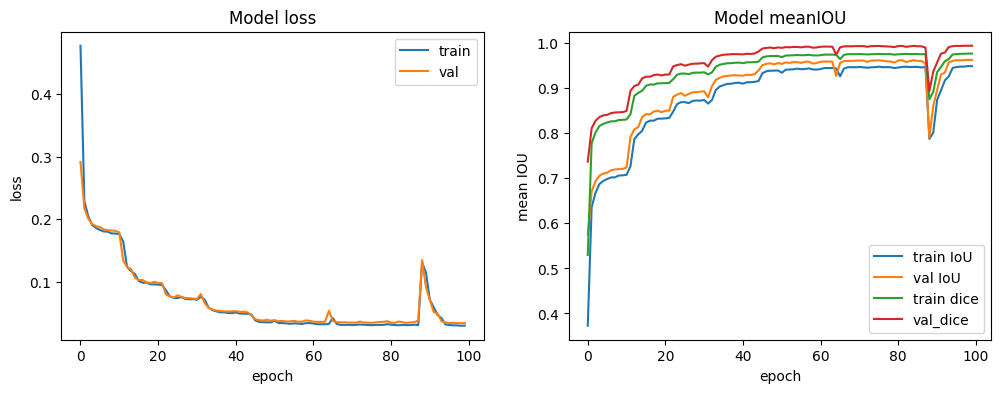

In [13]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(H['train_loss'])
plt.plot(H['test_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.subplot(122)
plt.plot(H['train_IoU'])
plt.plot(H['test_IoU'])
plt.plot(H['train_DC'])
plt.plot(H['test_DC'])
plt.title('Model meanIOU')
plt.ylabel('mean IOU')
plt.xlabel('epoch')

plt.legend(['train IoU', 'val IoU', 'train dice', 'val_dice'], loc='lower right')

plt.show()

In [14]:
def make_prediction(model, image):
	image = torch.Tensor(image).permute((2, 0, 1)).to(DEVICE)
	image = torch.unsqueeze(image, 0)
	# set model to evaluation mode
	model.eval()
	# turn off gradient tracking
	with torch.no_grad():
		predMask = model(image)
		predMask = softmax(predMask)
		predMask = torch.squeeze(predMask, 0)
		predMask = predMask.permute((1, 2, 0))
		predMask = predMask.cpu().detach().numpy()
		predMask = np.argmax(predMask, axis=-1)
		predMask = np.expand_dims(predMask, axis=-1)
		# filter out the weak predictions and convert them to integers
		return predMask.astype(np.uint8)


In [15]:
def getPredImg(image_path):     
    image = cv2.imread(image_path)
    image = image[10:-10, 10:-10,:]
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT))
    image = image / 255
    return image

def getPredMask(mask_path):
    mask = cv2.imread(mask_path)
    mask = mask[10:-10, 10:-10,:]
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = cv2.resize(mask, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT), interpolation=cv2.INTER_NEAREST)
    mask = np.expand_dims(mask, axis=-1)
    mask = encode_mask(mask)
    return mask

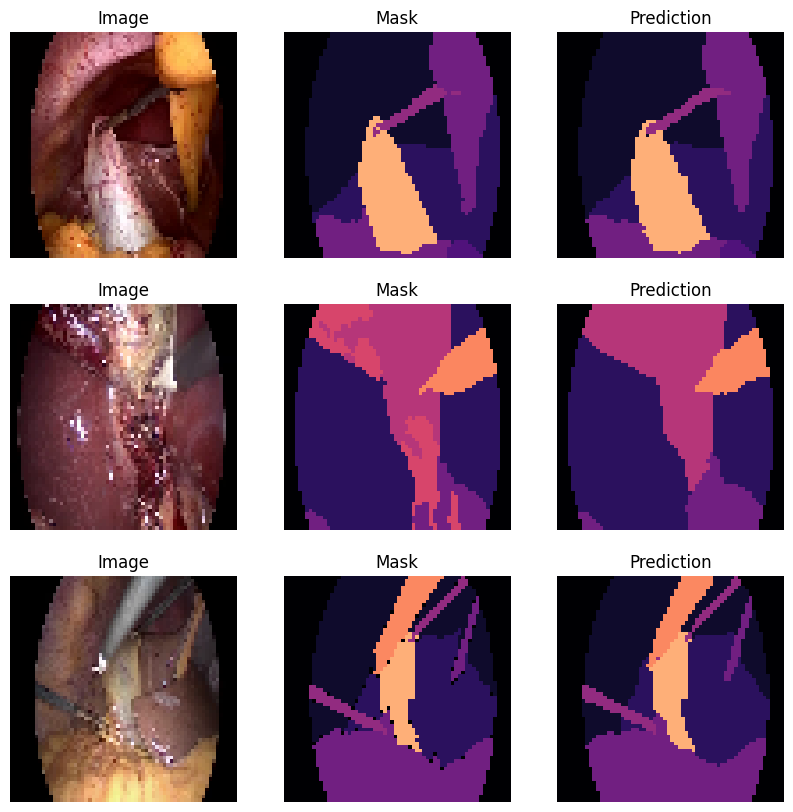

In [18]:
plt.figure(figsize=(10,10))
for i in range(3):    

    idx = random.randint(0, len(testImages) -1)
    img = getPredImg(testImages[idx])
    mask = getPredMask(testMasks[idx])
    
    plt.subplot(331 + 3*i)
    plt.imshow(img)
    plt.title('Image')
    plt.axis("off")

    mask = np.argmax(mask, axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    plt.subplot(332 + 3*i)
    plt.imshow(mask, cmap='magma', norm=plt.Normalize(vmin=0, vmax=12))
    plt.title('Mask')
    plt.axis("off")

    pred = make_prediction(uformer, img)
    plt.subplot(333 + 3*i)
    plt.imshow(pred, cmap='magma', norm=plt.Normalize(vmin=0, vmax=12))
    plt.title('Prediction')
    plt.axis("off")

plt.show()

 --- 
 TFG - Alejandro García Mota